In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
from plantcv import plantcv as pcv

from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [5]:
transform = transforms.ToTensor()

In [6]:
class CustomSegmentationDatasetCup(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = Image.open(self.image_paths + "\/" + image_path)
        #image = image.convert('L')
        
        cup_label = loadmat(self.label_paths + "\/" +label_path).get('mask')
        
        cup_label[cup_label ==1] = 0
        #cup_label[cup_label == 2] = 255
        
        # cup_label = crop_image(np.array(cup_label), 20, 40)
        #cup_label = create_multichannel_mask(cup_label)
        
        if self.transform:
            image = self.transform(image)#.to(device)
            image = image/255
            #image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
            
            cup_label = Image.fromarray(cup_label)

            cup_label = self.transform(cup_label)
            cup_label = cup_label.to(torch.float)
        # label = torch.from_numpy(label)
        # label = label.to(torch.long)#.to(device)
        #combined_labels_tensor = torch.stack([disk_label, cup_label], dim=1)
        
        return image, cup_label

In [7]:
class CustomSegmentationDatasetDisk(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform= transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = Image.open(self.image_paths + "\/" + image_path)
        #image = image.convert('L')
        
        disk_label = loadmat(self.label_paths + "\/" +label_path).get('mask')
        disk_label[disk_label == 2] = 1
        
        # disk_label = crop_image(np.array(disk_label), 20, 40)
        #disk_label = create_multichannel_mask(disk_label)
        if self.transform:
            image = self.transform(image)#.to(device)
            image = image/255
            #image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
            
            disk_label = Image.fromarray(disk_label)
            disk_label = self.transform(disk_label)
            disk_label = disk_label.to(torch.float)

        # label = torch.from_numpy(label)
        # label = label.to(torch.long)#.to(device)
        #combined_labels_tensor = torch.stack([disk_label, cup_label], dim=1)
        return image, disk_label

In [8]:
data_transform = transforms.Compose([
    #transform.Lambda(to_grayscale_pil),
    transforms.Resize((256, 256), antialias=True),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

In [9]:
train_dataset_disk = CustomSegmentationDatasetDisk(r''+folder_path+r'\Data\ImagesCroppedAugmented\Train', r''+folder_path+r'\Data\LabelsCroppedAugmented\Train', data_transform)
valid_dataset_disk = CustomSegmentationDatasetDisk(r''+folder_path+r'\Data\ImagesCroppedAugmented\Valid', r''+folder_path+r'\Data\LabelsCroppedAugmented\Valid', data_transform)

In [33]:
train_dataset_cup = CustomSegmentationDatasetCup(r''+folder_path+r'\Data\ImagesCroppedAugmented\Train', r''+folder_path+r'\Data\LabelsCroppedAugmented\Train', data_transform)
valid_dataset_cup = CustomSegmentationDatasetCup(r''+folder_path+r'\Data\ImagesCroppedAugmented\Valid', r''+folder_path+r'\Data\LabelsCroppedAugmented\Valid', data_transform)

In [34]:
batchSize = 64
train_data_disk = torch.utils.data.DataLoader(train_dataset_disk, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data_disk = torch.utils.data.DataLoader(valid_dataset_disk, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

train_data_cup = torch.utils.data.DataLoader(train_dataset_cup, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data_cup = torch.utils.data.DataLoader(valid_dataset_cup, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [12]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [13]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


In [14]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [15]:
class LinkNetBase(nn.Module):
    """
    Generate model architecture
    """

    def __init__(self, n_classes=1, num_channels = 3):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNetBase, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)
        self.encoder5 = Encoder(512, 1024, 3, 2, 1)
        self.encoder6 = Encoder(1024, 2048, 3, 2, 1)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)
        self.decoder5 = Decoder(1024, 512, 3, 2, 1, 1)
        self.decoder6 = Decoder(2048, 1024, 3, 2, 1, 1)

        # Classifier
        self.tp_conv_fin = nn.ConvTranspose2d(64, n_classes, 2, 2, 0)


        
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 2, 2, 0),
                                nn.BatchNorm2d(16),
                                nn.ReLU(inplace=True),)
        self.tp_conv3 = nn.ConvTranspose2d(16, n_classes, 2, 2, 0)

        
        self.lsm = nn.LogSoftmax(dim=1) #Sigmoid/SoftMax
        
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax(dim=1)
    
    # def conv_to_match_channels(self, input_tensor, target_tensor):
    #     # Apply a convolution to match the number of channels in input_tensor with target_tensor
    #     num_channels_input = input_tensor.shape[1]
    #     num_channels_target = target_tensor.shape[1]
    
    #     if num_channels_input < num_channels_target:
    #         # Apply a convolution to increase the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     elif num_channels_input > num_channels_target:
    #         # Apply a convolution to decrease the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     else:
    #         # No need to change channels
    #         return input_tensor
    
    #     return F.relu(conv_layer(input_tensor))
            
    def forward(self, x):
        # Initial block
        # Assuming x is a tuple with (original_image, distance_transform)
        #x = torch.cat(x, dim=1) # Concatenate along the channel dimension
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        #e5 = self.encoder5(e4)
        #e6 = self.encoder5(e5)
        
        # Decoder blocks
        d4 = e3 + self.decoder4(e4)
        #d6 = e5 + + self.decoder5(e6)
        #d5 = e4 + self.decoder5(e5)
        #d4 = e3 + self.decoder4(d5)
        d3 = e2 + self.decoder3(d4)
        #d3 = e2 + self.decoder3(e3)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        #y = self.tp_conv_fin(d1)
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)
        # y = self.conv3(y)
        # y = self.tp_conv3(y)
        y = self.sigm(y)
        
        return y

In [16]:
def get_IoU(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    intersection = torch.logical_and(output, target).sum().item()
    union = torch.logical_or(output, target).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [17]:
def get_accuracy(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    correct_pixels = torch.eq(output, target).sum().item()
    total_pixels = target.numel()

    accuracy = correct_pixels / total_pixels
    return accuracy

In [18]:
num_epochs = 20
best_val_loss = float('inf')
early_stop_patience = 5
learning_rate = 0.001
weight_decay = 0.01

In [19]:
model_cup = LinkNetBase()
model_cup.to(device)
optimizer_cup = torch.optim.Adam(model_cup.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = DiceBCELoss()
print(model_cup)

LinkNetBase(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [20]:
model_disk = LinkNetBase()
model_disk.to(device)
optimizer_disk = torch.optim.Adam(model_disk.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = DiceBCELoss()
print(model_disk)

LinkNetBase(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [21]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0

for epoch in range(num_epochs): 
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model_disk.train() 
    for images, labels_disk in train_data_disk: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels_disk= labels_disk.to(device) 
  
        #Calculating the model output and the cross entropy loss 
        outputs = model_disk.forward(images) 
        
        loss = criterion(outputs, labels_disk) 
        #Updating weights according to calculated loss 
        optimizer_disk.zero_grad() 
        loss.backward() 
        optimizer_disk.step() 
        train_loss += loss.item() 
        
        outputs = (outputs > 0.5).float()
        
        batch_iou = get_IoU(outputs, labels_disk)
        total_iou += batch_iou

        batch_accuracy = get_accuracy(outputs, labels_disk)
        total_accuracy += batch_accuracy
        
        total_samples += images.size(0)
            
    average_iou_train = total_iou / total_samples
    average_accuracy_train = total_accuracy / total_samples
    
    model_disk.eval()
    with torch.no_grad():
        for i, (images, labels_disk) in enumerate(valid_data_disk):
            images = images.to(device) 
            labels_disk = labels_disk.to(device)
            
            outputs = model_disk(images) 
            loss = criterion(outputs, labels_disk)
            #dice_coef = dice_coefficient(outputs, labels_disk)
            valid_loss += loss.item() 
            
            outputs = (outputs > 0.5).float()
            
            batch_iou = get_IoU(outputs, labels_disk)
            total_iou += batch_iou

            batch_accuracy = get_accuracy(outputs, labels_disk)
            total_accuracy += batch_accuracy
            
            total_samples += images.size(0)
            
    average_iou_valid = total_iou / total_samples
    average_accuracy_valid = total_accuracy / total_samples
    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data_disk))
    valid_loss_list.append(valid_loss/len(valid_data_disk)) 
    print(f"Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]} IoU_train = {average_iou_train}  Iou_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

Epoch 1/100: Training loss = 0.21336730103939772 Validation loss = 0.19984037056565285 IoU_train = 0.0002969093837615877  Iou_valid = 0.00023750360126178533 Accuracy_train = 0.013177959016256936 Accuracy_valid = 0.013234281283443406
Epoch 2/100: Training loss = 0.11996713606640697 Validation loss = 0.1706919465214014 IoU_train = 0.00013610130077545954  Iou_valid = 0.00012248569157952488 Accuracy_train = 0.01326273491020649 Accuracy_valid = 0.013284508255811537
Epoch 3/100: Training loss = 0.09165809280239046 Validation loss = 0.12852613255381584 IoU_train = 8.791925600305356e-05  Iou_valid = 8.205561265448705e-05 Accuracy_train = 0.013315463542408873 Accuracy_valid = 0.013326174846492898
Epoch 4/100: Training loss = 0.07224629260599613 Validation loss = 0.09376708790659904 IoU_train = 6.478315010461371e-05  Iou_valid = 6.154268859072552e-05 Accuracy_train = 0.013318077087726757 Accuracy_valid = 0.013325140240764727
Epoch 5/100: Training loss = 0.059530001948587596 Validation loss = 0.0

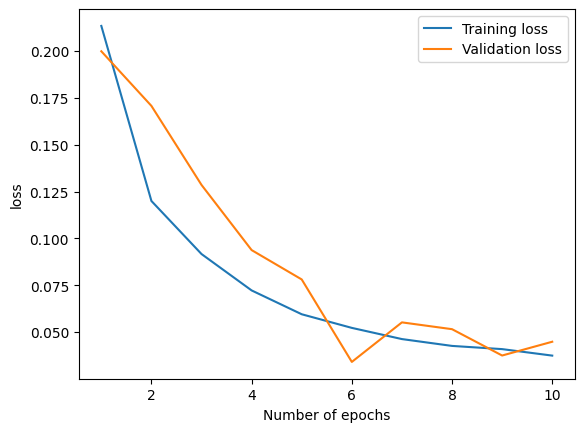

In [22]:
#plt.subplot(2, 1, 1)
plt.plot(range(1,success_epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,success_epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [35]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0

for epoch in range(num_epochs): 
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model_cup.train() 
    for images, labels_cup  in train_data_cup: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels_cup= labels_cup.to(device) 
  
        #Calculating the model output and the cross entropy loss 
        outputs = model_cup.forward(images) 

        loss = criterion(outputs, labels_cup)
        
        #Updating weights according to calculated loss 
        optimizer_cup.zero_grad() 
        loss.backward() 
        optimizer_cup.step() 
        train_loss += loss.item() 

        outputs = (outputs > 0.5).float()
        
        batch_iou = get_IoU(outputs, labels_cup)
        total_iou += batch_iou

        batch_accuracy = get_accuracy(outputs, labels_cup)
        total_accuracy += batch_accuracy
        
        total_samples += images.size(0)
            
    average_iou_train = total_iou / total_samples
    average_accuracy_train = total_accuracy / total_samples
    
    model_cup.eval()
    with torch.no_grad():
        for i, (images, labels_cup) in enumerate(valid_data_cup):
            
            images = images.to(device) 
            labels_cup = labels_cup.to(device)
            
            outputs = model_cup(images) 
            #dice_coef = dice_coefficient(outputs, labels_cup)
            
            loss = criterion(outputs, labels_cup) 
            valid_loss += loss.item() 

            outputs = (outputs > 0.5).float()
            
            batch_iou = get_IoU(outputs, labels_cup)
            total_iou += batch_iou

            batch_accuracy = get_accuracy(outputs, labels_cup)
            total_accuracy += batch_accuracy
            
            total_samples += images.size(0)
            
    average_iou_valid = total_iou / total_samples
    average_accuracy_valid = total_accuracy / total_samples
    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data_cup))
    valid_loss_list.append(valid_loss/len(valid_data_cup)) 
    print(f"Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]} IoU_train = {average_iou_train}  IoU_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

Epoch 1/100: 

KeyboardInterrupt: 

In [ ]:
#plt.subplot(2, 1, 1)
plt.plot(range(1,success_epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,success_epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [25]:
folder = r''+folder_path+r'\Data'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results'
test_results_disk_folder = folder + '\Test_results_disk'
test_results_cup_folder = folder + '\Test_results_cup'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [ ]:
# #--------------------!!!!!!!!--------------------
# test_results_disk_files = os.listdir(test_results_disk_folder)
# test_results_cup_files = os.listdir(test_results_cup_folder)

In [26]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [27]:
images_test_gt = []
for file in test_gt_files:
    images_test_gt.append(test_gt_folder + "\/" + file)

In [ ]:
# #--------------------!!!!!!!!--------------------
# images_test_result_disk = []
# images_test_result_cup = []
# for file in test_results_disk_files:
#     images_test_result_disk.append(test_results_disk_folder + "\/" + file)

# for file in test_results_cup_files:
#     images_test_result_cup.append(test_results_cup_folder + "\/" + file)

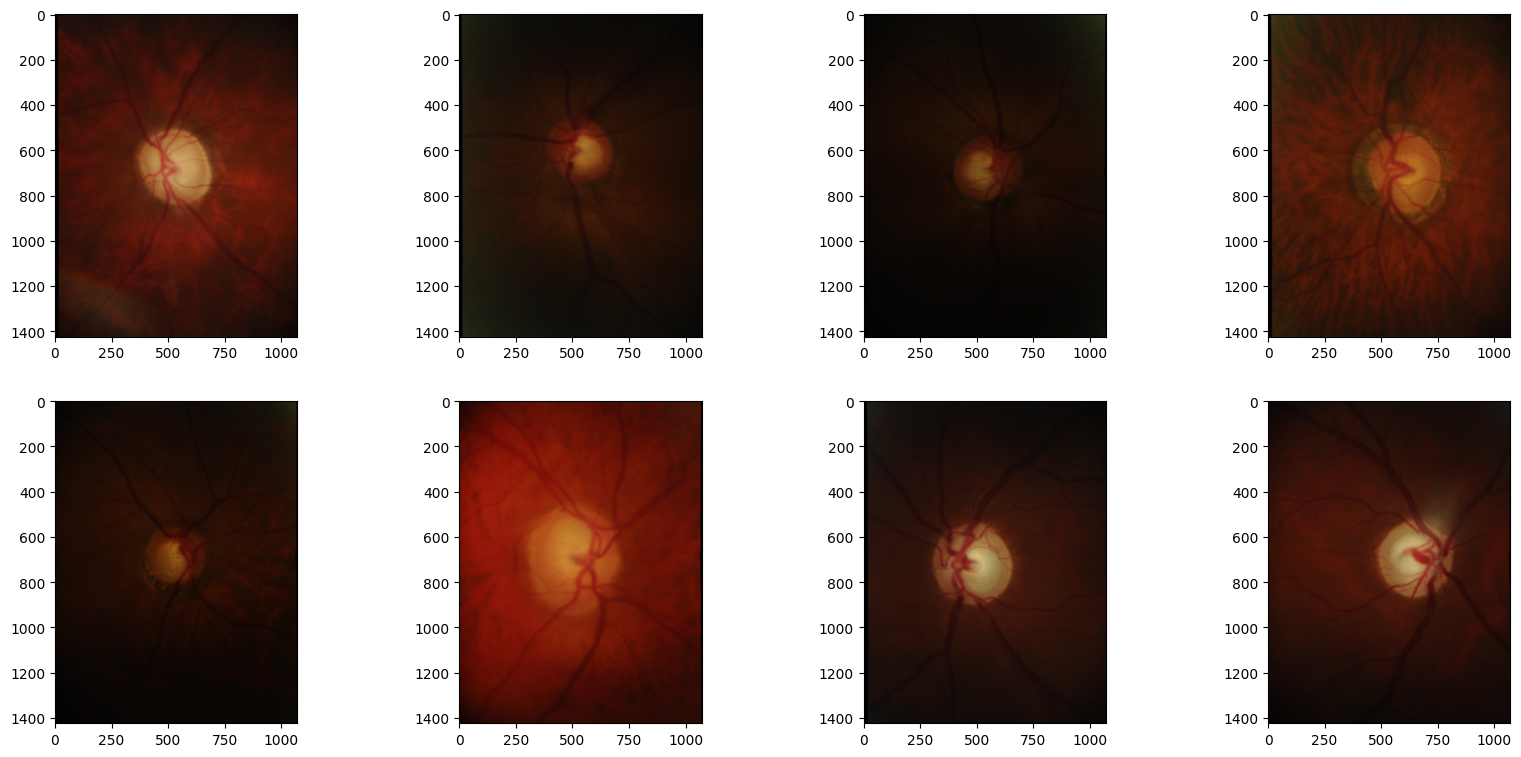

In [28]:
plt.figure(figsize=(20,200))
columns = 4
counter =0
for i, image in enumerate(images_test):
    if counter == 8:
        break
    plt.subplot(int(len(images_test) / columns + 1), columns, i + 1)
    plt.imshow(Image.open(image))
    counter +=1

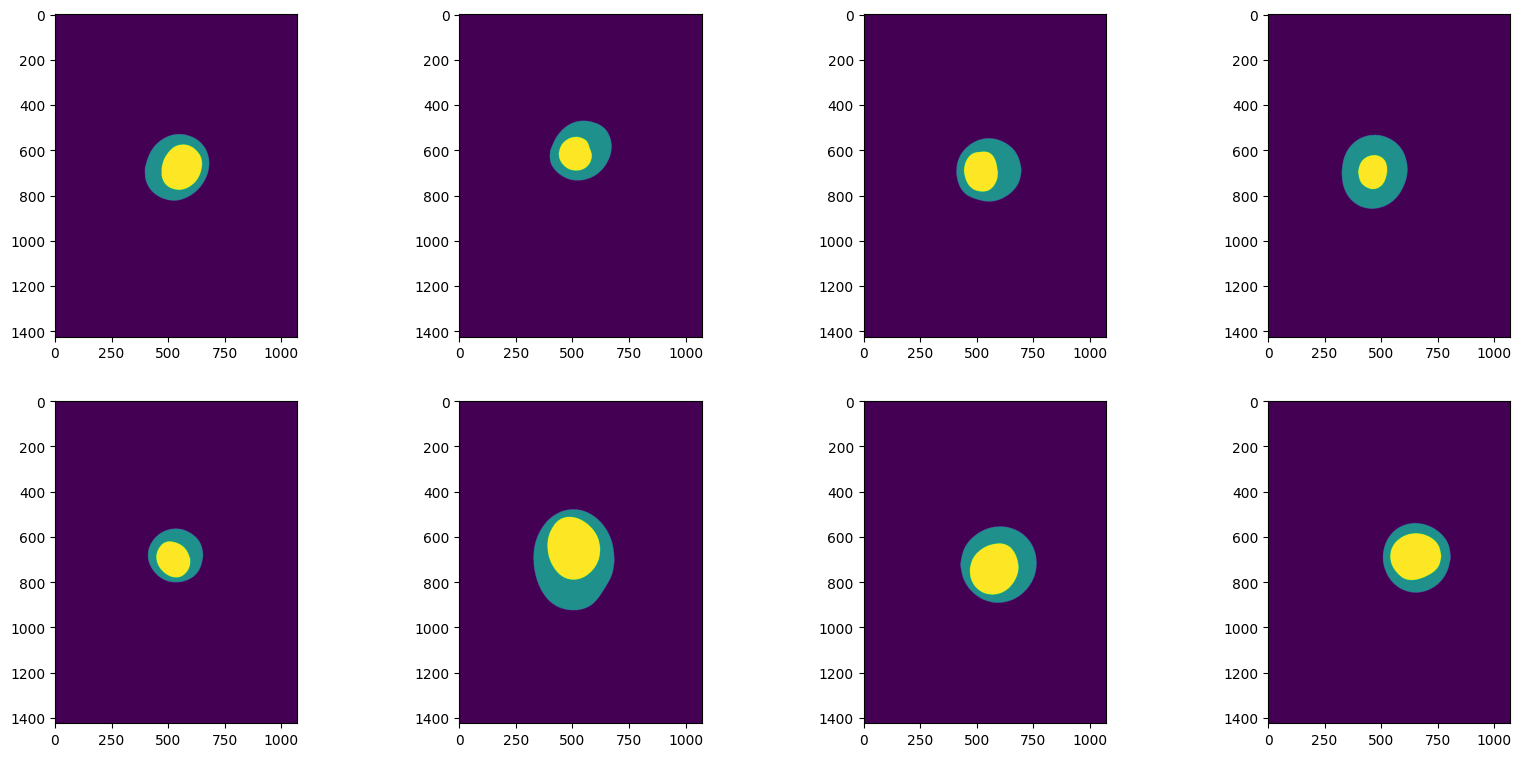

In [29]:
plt.figure(figsize=(20,200))
columns = 4
counter =0
for i, image in enumerate(images_test_gt):
    if counter == 8:
        break
    plt.subplot(int(len(images_test_gt) / columns + 1), columns, i + 1)
    plt.imshow(loadmat(image).get('mask'))
    counter +=1

In [ ]:
# #--------------------!!!!!!!!--------------------
# plt.figure(figsize=(20,200))
# columns = 4
# counter = 0
# for i, image in enumerate(images_test_result_disk):
#     if counter ==8:
#         break
#     plt.subplot(int(len(images_test_result_disk) / columns + 1), columns, i + 1)
#     img = loadmat(image).get('mask')
#     plt.imshow(img)
#     counter +=1

In [ ]:
# #--------------------!!!!!!!!--------------------
# plt.figure(figsize=(20,200))
# columns = 4
# counter = 0
# for i, image in enumerate(images_test_result_cup):
#     if counter ==8:
#         break
#     plt.subplot(int(len(images_test_result_cup) / columns + 1), columns, i + 1)
#     img = loadmat(image).get('mask')
#     plt.imshow(img)
#     counter +=1

In [ ]:
# #--------------------!!!!!!!!--------------------
# device = 'cpu'
# torch.set_default_device(device)

# threshold = 0.8
# plt.figure(figsize=(20,10))
# columns = 4
# for i, image in enumerate(images_test_result_disk):
#     plt.subplot(int(len(images_test_result_disk) / columns + 1), columns, i + 1)
    
#     img = loadmat(image).get('mask')
#     img = (img-np.min(img))/(np.max(img)-np.min(img))
#     img =  torch.from_numpy(img)
#     #print (img)
#     img = img.numpy()
#     binary_mask = np.where(img > threshold, 1, 0)
#     # unique_values, counts = np.unique(binary_mask, return_counts=True)
#     # for value, count in zip(unique_values, counts):
#     #     print(str(value) +":    "+str(count))
    
#     #smoothed_image = cv2.GaussianBlur(binary_mask.astype(np.float32), (0, 0), sigmaX=2, sigmaY=2)
#     # Convert the result back to binary (threshold)
#     #binary_mask = cv2.threshold(smoothed_image, 0.5, 1, cv2.THRESH_BINARY)[1]
#     plt.imshow(binary_mask)
#     #break
#     #plt.show()

In [ ]:
# #--------------------!!!!!!!!--------------------
# device = 'cpu'
# torch.set_default_device(device)

# threshold = 0.6
# plt.figure(figsize=(20,10))
# columns = 4
# for i, image in enumerate(images_test_result_cup):
#     plt.subplot(int(len(images_test_result_cup) / columns + 1), columns, i + 1)
    
#     img = loadmat(image).get('mask')
#     img = (img-np.min(img))/(np.max(img)-np.min(img))
#     img =  torch.from_numpy(img)
#     img = img.numpy()
    
#     binary_mask = np.where(img > threshold, 1, 0)
#     # unique_values, counts = np.unique(binary_mask, return_counts=True)
#     # for value, count in zip(unique_values, counts):
#     #     print(str(value) +":    "+str(count))
#     #print(binary_mask)
#     #break
#     #smoothed_image = cv2.GaussianBlur(binary_mask.astype(np.float32), (0, 0), sigmaX=5, sigmaY=5)
#     # Convert the result back to binary (threshold)
#     #binary_mask = cv2.threshold(smoothed_image, 0.5, 1, cv2.THRESH_BINARY)[1]
#     plt.imshow(binary_mask)
#     #plt.show()

In [ ]:
output.shape

In [31]:
unique_values, counts = np.unique(output, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0.0:    262144


(512, 512, 1)


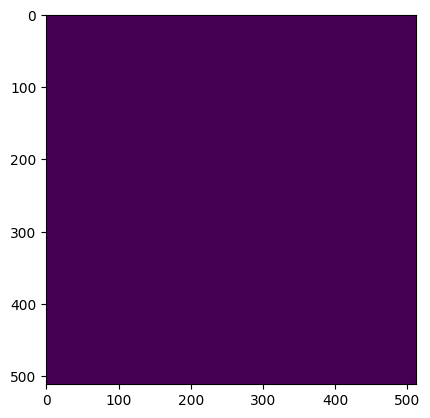

In [30]:
threshold = 0.3
model_disk.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        image = image.resize((512, 512), resample=Image.NEAREST)
        #image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)
        
        image = image.to(device) 
        output = model_disk(image)
        output = output.detach().cpu().numpy()[0]
        output = np.transpose(output, (1, 2, 0))
        # output = (output[0, :, :])
        # output = (output - np.min(output) ) / (np.max(output) - np.min(output))
        #output = (output > threshold)
        #output = (output[0, :, :] > threshold)
    
        # output = torch.stack(output).sum(dim=1) > 0
        # output = output.detach().cpu().numpy()[0]
        plt.imshow(output)
        print(output.shape)
        break
        # output_dict = {"mask": output}
        # savemat(test_results_disk_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

In [ ]:
threshold = 0.5
model_cup.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        image = Image.open(image)
        image = image.resize((512, 512), resample=Image.NEAREST)
        #image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)
        
        image = image.to(device) 
        output = model_cup(image)

        output = output.detach().cpu().numpy()[0]
        # output = (output[0, :, :])
        # output = (output - np.min(output) ) / (np.max(output) - np.min(output))
        # output = (output > threshold)
        output = (output[0, :, :] > threshold)
    
        # output = torch.stack(output).sum(dim=1) > 0
        # output = output.detach().cpu().numpy()[0]
        
        # plt.imshow(output)
        # print(output.shape)
        # break
        
        output_dict = {"mask": output}
        savemat(test_results_cup_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

# Combination_Logic
...

In [ ]:
threshold_disk = 0.7
threshold_cup = 0.5
for disk_path, cup_path in zip(images_test_result_disk, images_test_result_cup):
    disk_filename = os.path.basename(disk_path).strip(".mat")
    cup_filename = os.path.basename(cup_path).strip(".mat")
    if disk_filename == cup_filename:
        disk = loadmat(disk_path).get('mask')
        cup = loadmat(cup_path).get('mask')

        disk = (disk-np.min(disk))/(np.max(disk)-np.min(disk))
        disk =  torch.from_numpy(disk)
        binary_mask_disk = np.where(disk > threshold_disk, 1, 0)

        cup = (cup-np.min(cup))/(np.max(cup)-np.min(cup))
        cup =  torch.from_numpy(cup)
        binary_mask_cup = np.where(cup > threshold, 2, 0)

        final = np.copy(binary_mask_disk)
        final[binary_mask_cup == 2] = 2

        final_dict = {"mask": final} 
        savemat(test_results_folder + "\/" + disk_filename + ".mat", final_dict)

In [ ]:
test_results_files = os.listdir(test_results_folder)
images_test_result = []
for file in test_results_files:
    images_test_result.append(test_results_folder + "\/" + file)

In [ ]:
#--------------------!!!!!!!!--------------------
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(images_test_result):
    plt.subplot(int(len(images_test_result) / columns + 1), columns, i + 1)
    img = loadmat(image).get('mask')
    plt.imshow(img)
    
    # unique_values, counts = np.unique(img, return_counts=True)
    # for value, count in zip(unique_values, counts):
    #     print(str(value) +":    "+str(count))